Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 4

## Assignment

- [X] Watch Aaron Gallant's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [X] Do one-hot encoding. (Remember it may not work with high cardinality categoricals.)
- [X] Use scikit-learn for logistic regression.
- [X] Get your validation accuracy score.
- [X] Get and plot your coefficients.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.


## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Clean the data. For ideas, refer to [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide),  a "reference to problems seen in real-world data along with suggestions on how to resolve them." One of the issues is ["Zeros replace missing values."](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values)
- [ ] Make exploratory visualizations.
- [X] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from the previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```

#### Pipelines

[Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/compose.html) explains why pipelines are useful, and demonstrates how to use them:

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:
> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

### Reading
- [ ] [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)
- [ ] [Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)
- [ ] [Statistical Modeling: The Two Cultures](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).



In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module4')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [0]:
# import pandas_profiling
# train_features.profile_report()

In [39]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [0]:
# Splitting data into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels['status_group'], train_size = .8, test_size = .2, stratify = train_labels['status_group'])
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size = .75, test_size = .25, stratify = y_train)

In [6]:
# Checking sizes of features in each set
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(35640, 40)
(11880, 40)
(11880, 40)


In [7]:
# Checking sizes of targets in each set
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(35640,)
(11880,)
(11880,)


In [8]:
X_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2200
gps_height                   0
installer                 2208
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 224
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2056
recorded_by                  0
scheme_management         2331
scheme_name              16948
permit                    1881
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [9]:
train_total = X_train.copy()
train_total['target'] = y_train
train_total['target'].replace('non functional',0, inplace = True)
train_total['target'].replace('functional needs repair', 1, inplace = True)
train_total['target'].replace('functional',2,inplace = True)
# train_total['target'].unique()
train_total['target'] = train_total['target'].astype(int)
print(train_total['target'].dtypes)
train_total.head()

int64


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,target
25758,21204,10.0,2013-02-06,Makonde Water Population,473,Makonde water population,39.387728,-10.691913,Research,0,Ruvuma / Southern Coast,Mtopwa,Mtwara,90,33,Newala,Mpotwa,230,True,GeoData Consultants Ltd,VWC,Mitema,False,0,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,other,other,0
41724,61926,0.0,2012-10-18,Government Of Tanzania,0,Government,33.787811,-3.512481,Mwabaraturu Primary School,0,Internal,Chamani,Shinyanga,17,2,Maswa,Budekwa,0,True,GeoData Consultants Ltd,WUG,NaN,False,0,nira/tanira,nira/tanira,handpump,wug,user-group,other,other,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,2
55292,55539,0.0,2013-01-19,Gen,74,GEN,39.383006,-10.289752,Mtama Secondary School 2,0,Ruvuma / Southern Coast,Namindondi,Lindi,80,23,Lindi Rural,Mtama,1,False,GeoData Consultants Ltd,Parastatal,GEN Borehole Scheme,False,2010,india mark ii,india mark ii,handpump,parastatal,parastatal,never pay,never pay,salty,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,2
16127,12287,0.0,2013-02-18,Germany,964,DWE,35.424347,-10.573212,Kwa Triphoni,0,Lake Nyasa,Mbuyura A,Ruvuma,10,2,Songea Rural,Maposeni,250,True,GeoData Consultants Ltd,VWC,Mradi wa maji wa maposeni,True,2009,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,river,river/lake,surface,communal standpipe,communal standpipe,0
52638,16388,0.0,2011-07-27,Government Of Tanzania,0,Sengerema Water Department,32.798741,-2.613261,Kwa Malunguja,0,Lake Victoria,Kasisa B,Mwanza,19,5,Sengerema,Nyamatongo,0,True,GeoData Consultants Ltd,VWC,CDG,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty abandoned,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,2


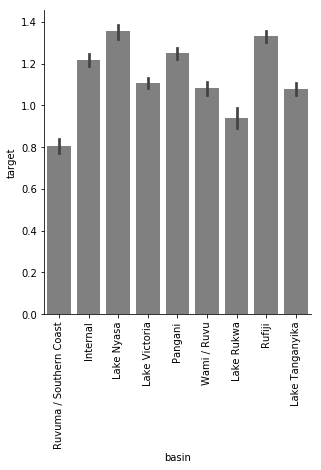

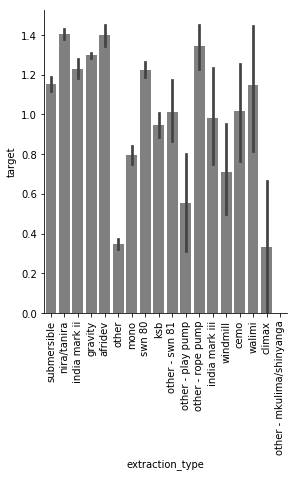

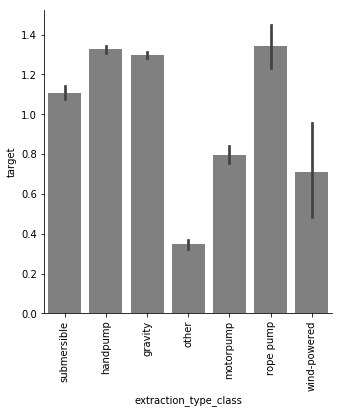

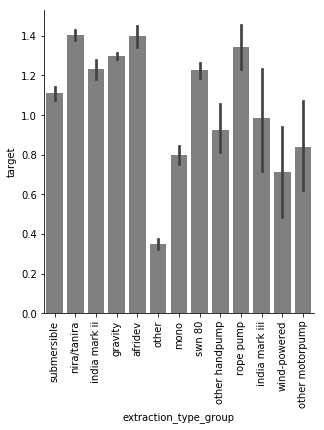

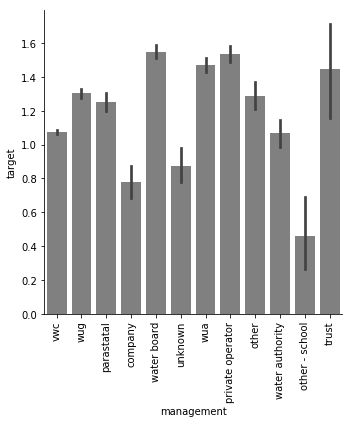

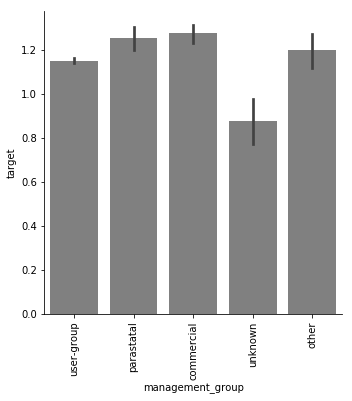

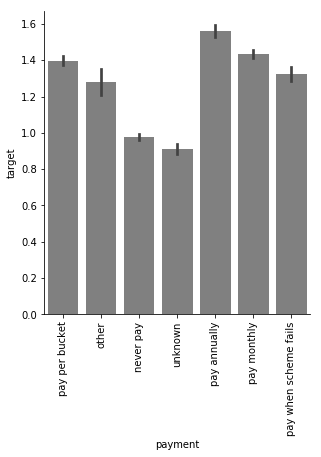

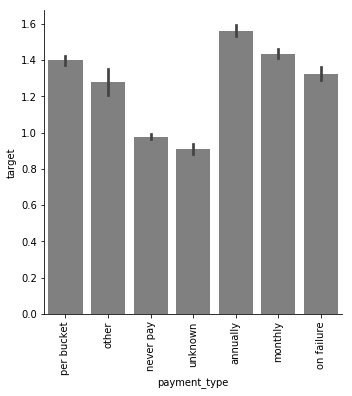

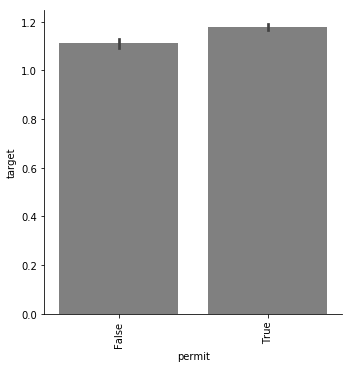

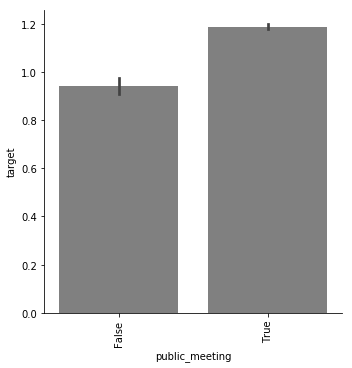

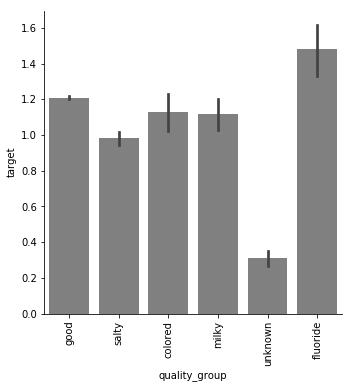

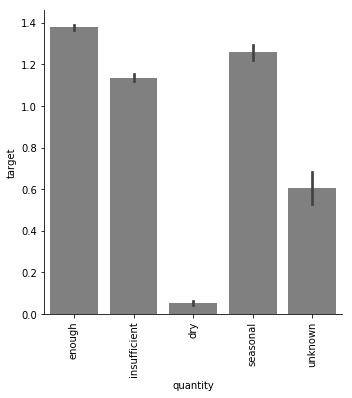

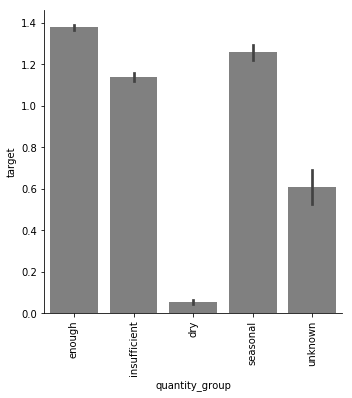

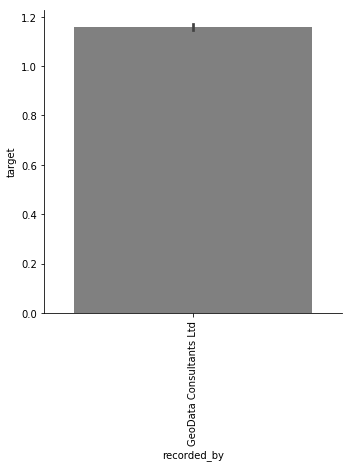

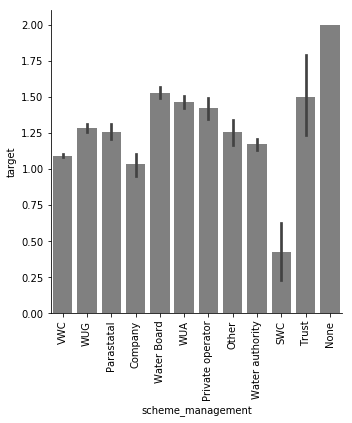

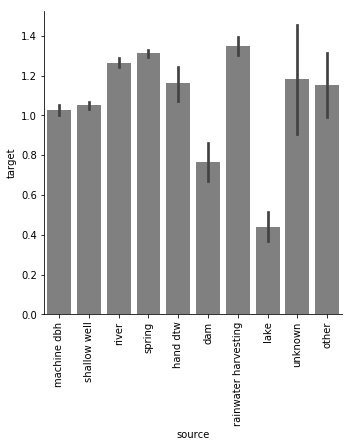

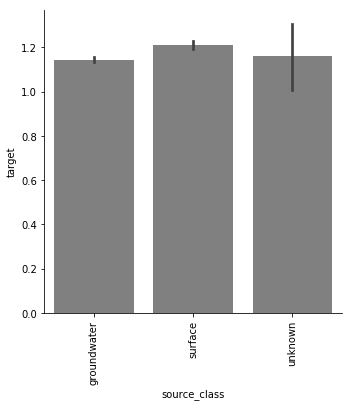

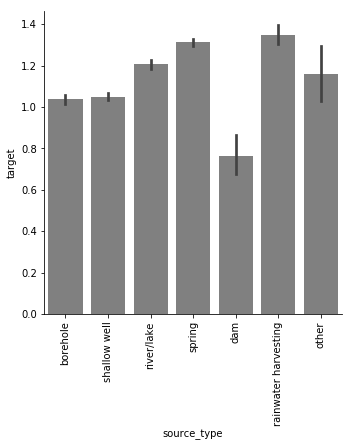

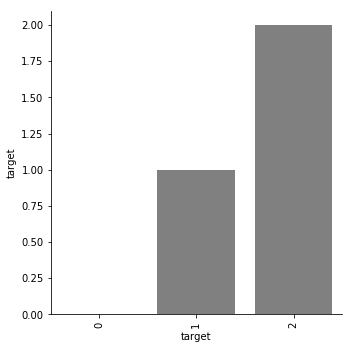

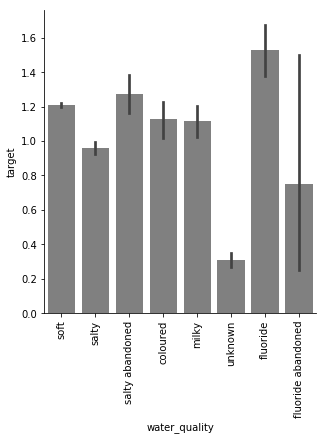

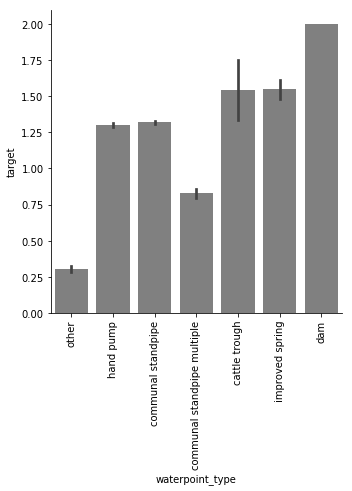

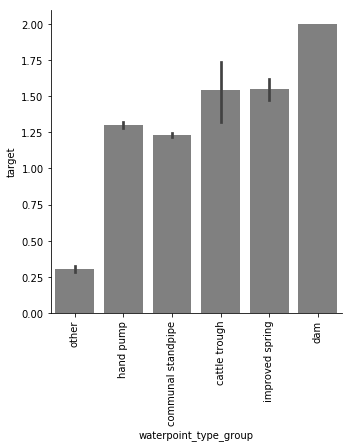

In [10]:
# Plotting categorical features vs. target

import seaborn as sns
import matplotlib.pyplot as plt
        
for col in sorted(train_total.columns):
  if train_total[col].nunique() < 20:
    sns.catplot(x = col, y = 'target', data = train_total, kind = 'bar', color = 'grey')
    plt.xticks(rotation='vertical')
    plt.show()

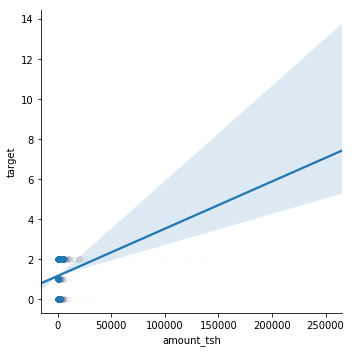

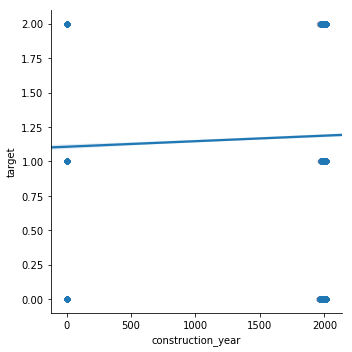

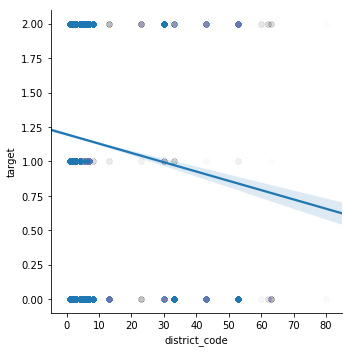

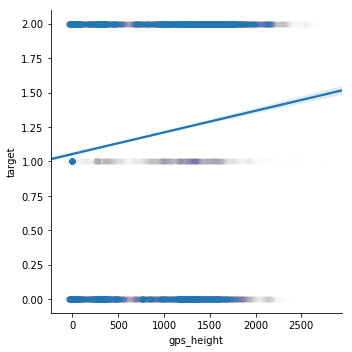

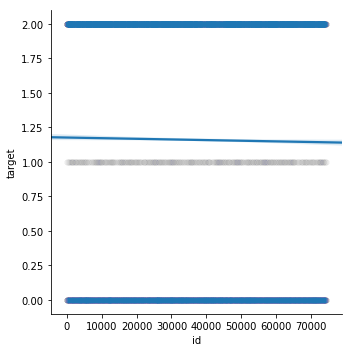

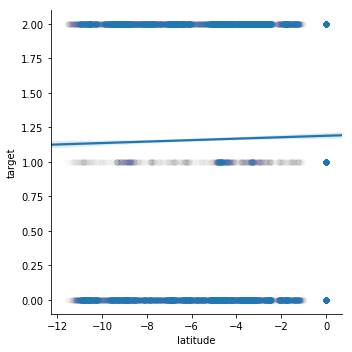

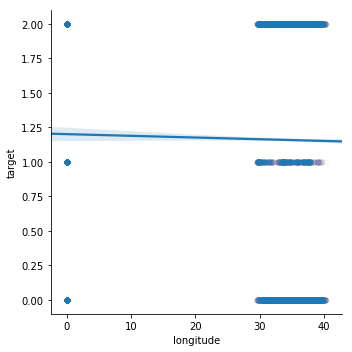

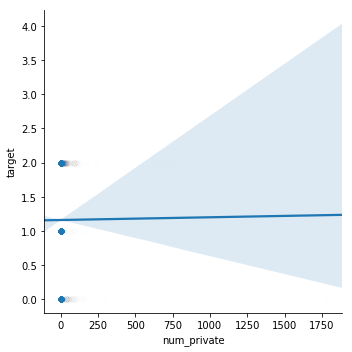

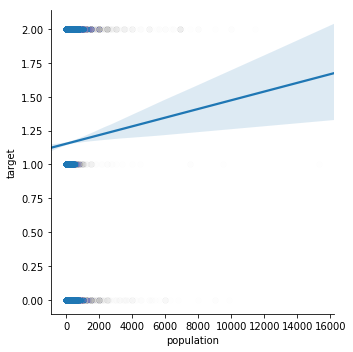

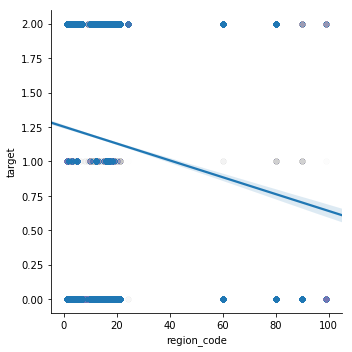

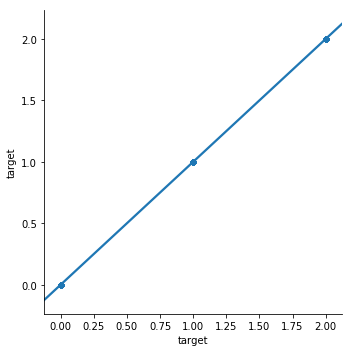

In [11]:
# Plotting numerical features vs. target
numeric = train_total.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='target', data=train_total, scatter_kws=dict(alpha=0.005))
    plt.show()

In [0]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

categorical_features = ['management', 'extraction_type', 'payment_type', 'permit', 'quantity', 'quality_group', 'source', 'public_meeting']
numeric_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]

encoder = ce.OneHotEncoder(use_cat_names = True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)


# Want to encode: 'management', 'extraction_type', 'payment_type', 'permit', 'region_code', 'quantity', 'quality_group', 'source', 'public_meeting'
# installer = dwe or not
# Bin date recorded by season?
# Age = year of data recording - year of construction (deal with construction year = 0)
# Need to encode region code as categorical instead of numerical if i want to use

# Look at longitude and latitude

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 5000)
model.fit(X_train_scaled, y_train)
print('Validation accuracy: ', model.score(X_val_scaled, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Validation accuracy:  0.7173400673400674


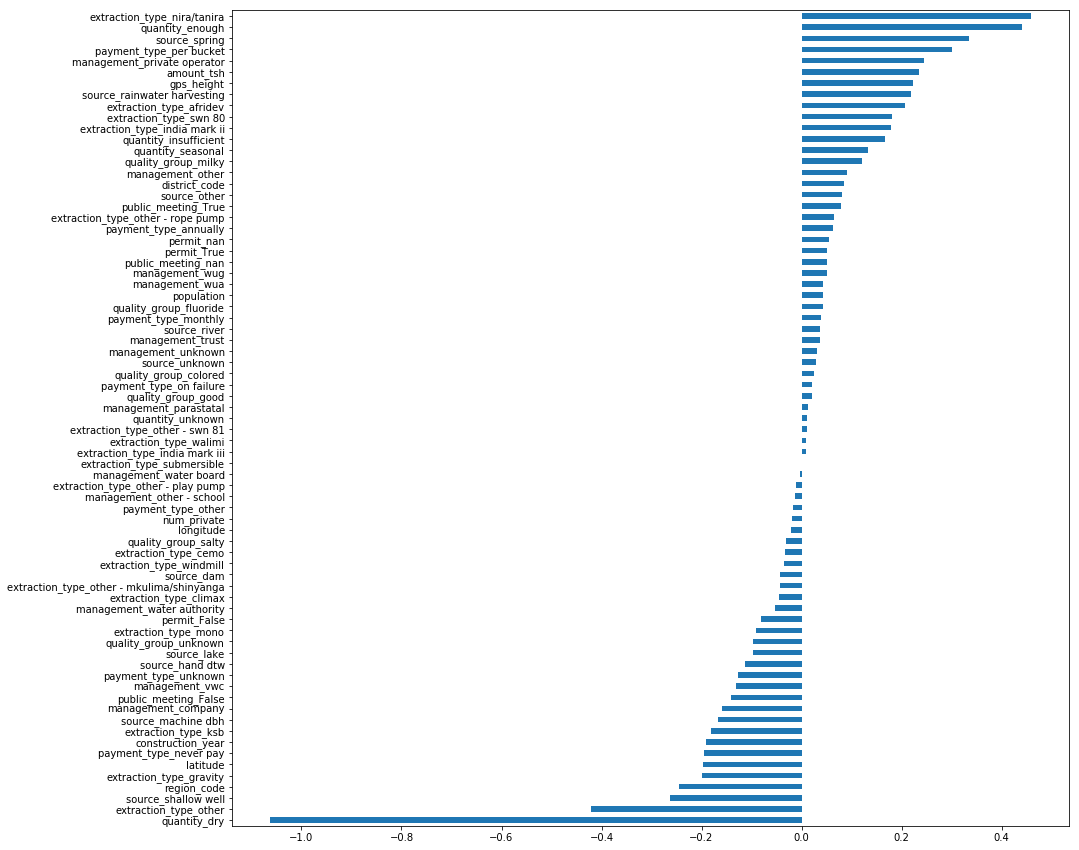

In [36]:
functional_coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize = (15,15))
functional_coefficients.sort_values().plot.barh();
  


In [30]:
model.classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [38]:
# Getting output file

train_features_subset = train_features[features]

train_features_encoded = encoder.transform(train_features_subset)

train_features_scaled = scaler.transform(train_features_encoded)

y_pred = model.predict(train_features_encoded)
y_pred.shape

(59400,)

In [47]:
y_pred = pd.Series(y_pred)
submission = y_pred.to_frame()
submission.head()

,0
0,functional
1,non functional
2,non functional
3,non functional
4,non functional


In [51]:
submission['status_group'] = submission[0]
submission.head()
submission[0] = train_features['id']
submission.head()
submission.columns = ['id', 'status_group']
submission.head()

,id,status_group
0,69572,69572
1,8776,8776
2,34310,34310
3,67743,67743
4,19728,19728


In [0]:
submission.to_csv('submission-01.csv', index=False)

In [45]:
sample = pd.read_csv(sample)
sample.head()


ValueError: ignored